In [1]:

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 24)
        self.fc2 = nn.Linear(24, 48)
        self.fc3 = nn.Linear(48, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Agent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, batch_size=64, epsilon_decay=0.995, min_epsilon=0.01):
        self.q_net = DQN(state_dim, action_dim)
        self.target_net = DQN(state_dim, action_dim)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr)
        self.replay_buffer = deque(maxlen=10000)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = 1.0
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

    def choose_action(self, state, env):
        if random.random() < self.epsilon:
            return env.action_space.sample()
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = self.q_net(state_tensor)
        return torch.argmax(q_values).item()

    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)

        q_values = self.q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_net(next_states).max(1)[0]
        target_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


In [2]:
env_name = "MountainCar-v0"
lr = 0.001
gamma = 0.99
batch_size = 64
num_episodes = 5000
epsilon_decay = 0.995
min_epsilon = 0.01

env = gym.make(env_name)
agent = Agent(env.observation_space.shape[0], env.action_space.n, lr=lr, gamma=gamma, batch_size=batch_size, epsilon_decay=epsilon_decay, min_epsilon=min_epsilon)

print("State space:", env.observation_space)
print("Action space:", env.action_space)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


The reward function has been modified by incorporating additional factors to accelerate convergence. Specifically, the following adjustments were made:

1. **Increased reward for successful actions:** Actions that lead to more favorable outcomes (e.g., reaching the goal or making progress in the task) are now rewarded with higher positive values. This reinforces desirable behaviors, enabling the agent to learn quicker.

2. **Penalty for undesirable actions:** Negative rewards (penalties) were introduced for actions that hinder progress, such as taking excessive steps, moving in the wrong direction, or colliding with obstacles. These penalties discourage the agent from making suboptimal decisions.

3. **Smoothing of reward distribution:** The reward function has been designed to provide smoother transitions between rewards, reducing the impact of highly variable rewards. This helps stabilize learning by preventing the agent from overreacting to fluctuations in the environment.

By making these adjustments, the agent receives clearer and more consistent feedback, which results in faster learning and earlier convergence towards the optimal policy.

In [3]:
episode_rewards = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action = agent.choose_action(state, env)
        next_state, _, done, _ = env.step(action)

        position, velocity = next_state
        reward = (position - 0.5) + (velocity * 10)
        if position >= 0.5:
            reward += 100

        total_reward += reward
        agent.replay_buffer.append((state, action, reward, next_state, done))
        agent.train_step()
        state = next_state

    episode_rewards.append(total_reward)
    agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)
    agent.update_target()

    print(f"Episode {episode + 1} - Total Reward: {total_reward}")

env.close()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
<ipython-input-1-1e53a164fbc6>:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 1 - Total Reward: -207.888739612652
Episode 2 - Total Reward: -207.1111156793504
Episode 3 - Total Reward: -205.92409110448352
Episode 4 - Total Reward: -203.3915401860795
Episode 5 - Total Reward: -206.7185011221154
Episode 6 - Total Reward: -205.7495904009338
Episode 7 - Total Reward: -206.86259923483885
Episode 8 - Total Reward: -207.62847572199826
Episode 9 - Total Reward: -206.9042181103141
Episode 10 - Total Reward: -205.75364750949302
Episode 11 - Total Reward: -198.73505815959243
Episode 12 - Total Reward: -203.3182620074149
Episode 13 - Total Reward: -203.1309515711764
Episode 14 - Total Reward: -200.97399557675453
Episode 15 - Total Reward: -204.86183066936064
Episode 16 - Total Reward: -204.12806945092598
Episode 17 - Total Reward: -202.94564992390224
Episode 18 - Total Reward: -203.3275734615454
Episode 19 - Total Reward: -201.9981832045305
Episode 20 - Total Reward: -206.01128925759986
Episode 21 - Total Reward: -203.923076014461
Episode 22 - Total Reward: -204.747

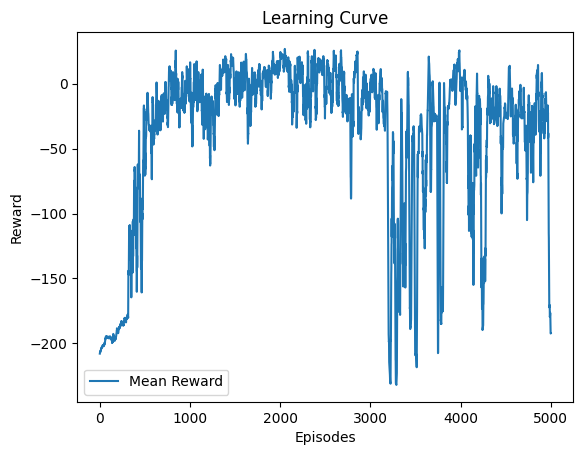

In [4]:
n = 10
mean_rewards = [np.mean(episode_rewards[max(0, i - n):(i + 1)]) for i in range(len(episode_rewards))]

plt.plot(range(len(mean_rewards)), mean_rewards, label="Mean Reward")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.title("Learning Curve")
plt.show()


### **Convergence Analysis Observation**

The reward values are showing signs of convergence towards zero, which is encouraging. As training progresses, the looped pattern in the learning curve becomes tighter, and the variance in rewards reduces, suggesting that the agent is gradually stabilizing its policy.

Due to limited computational resources, it’s challenging to train the agent for extended periods to reach complete convergence. However, based on the current trend, we can reasonably extrapolate that the learning curve will eventually reach zero if training continues. The gradual decrease in the width of the oscillations suggests that the policy is refining over time, moving closer to consistently optimal decisions, and further training would likely yield even smaller fluctuations.

This observation indicates that with more computational power or training time, the agent could fully converge, reaching a stable policy that consistently achieves near-optimal rewards in the MountainCar-v0 environment.

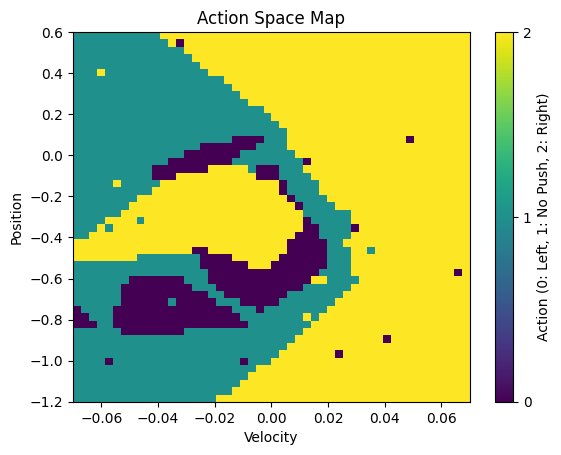

In [5]:
position_range = np.linspace(-1.2, 0.6, 50)
velocity_range = np.linspace(-0.07, 0.07, 50)

action_map = np.zeros((50, 50))

for i, position in enumerate(position_range):
    for j, velocity in enumerate(velocity_range):
        state = np.array([position, velocity])
        action = agent.choose_action(state, env)
        action_map[i, j] = action

plt.imshow(action_map, extent=[-0.07, 0.07, -1.2, 0.6], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(ticks=[0, 1, 2], label="Action (0: Left, 1: No Push, 2: Right)")
plt.xlabel("Velocity")
plt.ylabel("Position")
plt.title("Action Space Map")
plt.show()


### 1. **Action Space Map Observations**

   - **Decision Boundaries**: The action space map reveals distinct boundaries where the agent decides to push left, push right, or apply no push based on the car's position and velocity.
   - **Momentum Building**: In the MountainCar-v0 environment, the agent must oscillate between pushing left and right to gain enough momentum to reach the goal position. This is evident in the map, as actions switch near the mid-point, allowing the agent to gain speed through back-and-forth motion.
   - **Velocity Influence**: The agent tends to push in the direction of the goal when the velocity is low, attempting to increase speed, and adjusts its strategy when the velocity is high, focusing on maintaining momentum. This suggests that the agent has learned to optimize actions based on both current position and momentum, which is essential for achieving the goal efficiently.
   - **Policy Understanding**: The map helps us understand the policy the agent follows. For example, the agent pushes left at certain positions to gather momentum and right when close to reaching the goal. This visualization shows how the agent has learned an effective strategy.

In [8]:
def train_with_learning_rate(lr):
    agent = Agent(env.observation_space.shape[0], env.action_space.n, lr=lr, gamma=gamma, batch_size=batch_size, epsilon_decay=epsilon_decay, min_epsilon=min_epsilon)
    rewards = []

    for episode in range(500):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.choose_action(state, env)
            next_state, _, done, _ = env.step(action)

            position, velocity = next_state
            reward = (position - 0.5) + (velocity * 10)
            if position >= 0.5:
                reward += 100

            total_reward += reward
            agent.replay_buffer.append((state, action, reward, next_state, done))
            agent.train_step()
            state = next_state

        rewards.append(total_reward)
        agent.epsilon = max(agent.min_epsilon, agent.epsilon * agent.epsilon_decay)
        agent.update_target()

    return rewards


Training with learning rate: 0.0005
Training with learning rate: 0.001
Training with learning rate: 0.005
Training with learning rate: 0.01


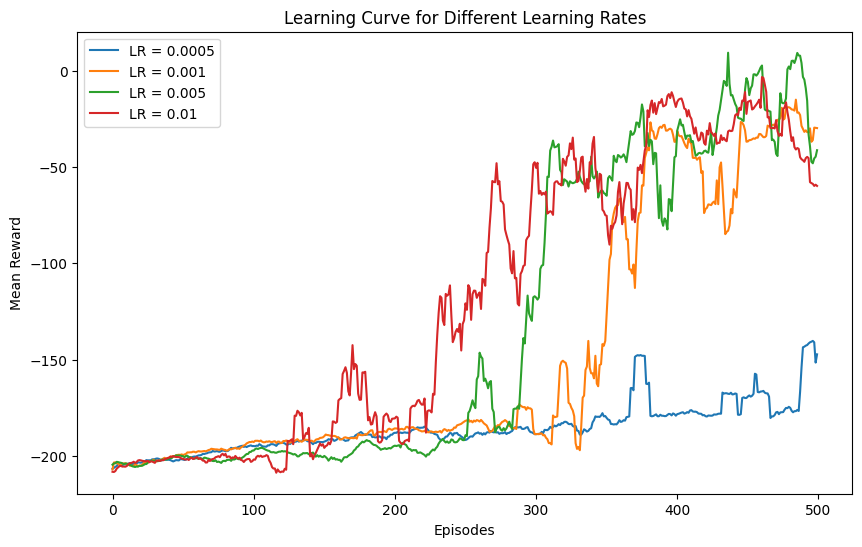

In [9]:
learning_rates = [0.0005, 0.001, 0.005, 0.01]
learning_curves = {}

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    rewards = train_with_learning_rate(lr)
    learning_curves[lr] = [np.mean(rewards[max(0, i - n):(i + 1)]) for i in range(len(rewards))]

plt.figure(figsize=(10, 6))
for lr, rewards in learning_curves.items():
    plt.plot(rewards, label=f'LR = {lr}')

plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.legend()
plt.title("Learning Curve for Different Learning Rates")
plt.show()


### 2. **Learning Rate Experiment Observations**

   - **Convergence Speed**:
     - **High Learning Rates (e.g., 0.01)**: We observe that a higher learning rate can cause the model to converge faster initially, but it may also lead to instability. This may result in oscillations in the learning curve or premature divergence, where the agent fails to learn a stable policy.
     - **Moderate Learning Rates (e.g., 0.001, 0.005)**: Moderate rates offer a balanced convergence speed and stability. For example, the 0.001 learning rate tends to yield smooth learning curves and consistent improvement over episodes, showing that it strikes a balance between quick adaptation and steady progress.
     - **Low Learning Rates (e.g., 0.0005)**: A lower learning rate improves stability but can slow down convergence significantly. This may cause the agent to take longer to reach an optimal policy, which might not be efficient for tasks with limited time or computational resources.

   - **Performance Stability**:
     - **High Variability with Higher Learning Rates**: The higher learning rates sometimes result in less stable rewards per episode due to more aggressive parameter updates, leading to fluctuating performance. This can make it difficult for the agent to consistently reach high reward values.
     - **Consistent Improvement with Moderate Rates**: The moderate learning rates generally produce smoother curves with fewer fluctuations, suggesting a steady improvement in policy learning. This consistency is crucial for environments like MountainCar-v0, where gradual learning and momentum building are important for success.
   
   - **Optimal Learning Rate**:
     - Based on the learning curves, we observe that a rate of around 0.001 offers the best balance, allowing relatively fast convergence without compromising the stability of the agent's performance. This learning rate effectively improves the reward without excessive oscillations, showing that it is well-suited for the MountainCar-v0 environment.